In [376]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

In [ ]:
'''

This script is meant to take in data exported from OVITO and analyze the displaced particles, count the number of vacancies
present within the crystal sample, measure the track length, calculate the theoretical vacancy density as a function of 
depth into the crystal, and find the track width as a function of track depth into the sample. 

This notebook is a continuous work in progress, and especially the proposed methodology to find the track width may need \
to be modified in the future.

Currently to calculate the number of vacancies we say that it is a 1:1 relationship with the number of displaced atoms, which 
is what we are specifically examining in the code below. 

To find the vacancy density as a function of depth, we take volume slices perpendicular to the direction of the inbound gold
ion and count the number of vacancies in this rectangular region over many different depth options. The starting and ending
points of these rectangles are easily modifiable by changing the starting and ending values in the function input.

To find the track width, we first specify along which axis we want to find the track width and then about the 0-point which the
gold ion was initially shot in on (for example at x = 0 or x = 10 or y = 20) for a particular depth we do a complete 360 degree
rotation about the other two axes and find the atoms which have the shortest radius at that particular point (with a specified 
small tolerance value). The values returned are the predicted radii, so we multiply the answer by 2 in the final plot.

***This is open to being modified since this was a rudimentary idea.***

@author: kmream


'''

### Step 1: Get Data Loaded and Visualized

In [493]:
data_1 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_50000_5pico', sep = " ").sort_values(by = 'id')
data_2 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_46313_11pico', sep = " ").sort_values(by = 'id')
data_3 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_40000_5pico', sep = " ").sort_values(by = 'id')
data_4 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_15000_5pico', sep = " ").sort_values(by = 'id')
data_5 = pd.read_csv('5_17_2025_runs/5_17_2025_10keV_ters_zbl_10000_15pico_nomin', sep = " ").sort_values(by = 'id')

data_elec_1 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_50000_20pico_elec', sep = " ").sort_values(by = 'id')
data_elec_2 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_46313_20pico_elec', sep = " ").sort_values(by = 'id')
data_elec_3 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_40000_20pico_elec', sep = " ").sort_values(by = 'id')
data_elec_4 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_15000_20pico_elec', sep = " ").sort_values(by = 'id')
data_elec_5 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_10000_20pico_elec', sep = " ").sort_values(by = 'id')

seeds = ['50000', '46313', '40000', '15000', '10000']

data_1['x'], data_2['x'], data_3['x'], data_4['x'], data_5['x'] = data_1['x'].values / 10, data_2['x'].values / 10, data_3['x'].values / 10, data_4['x'].values / 10, data_5['x'].values / 10
data_1['y'], data_2['y'], data_3['y'], data_4['y'], data_5['y'] = data_1['y'].values / 10, data_2['y'].values / 10, data_3['y'].values / 10, data_4['y'].values / 10, data_5['y'].values / 10
data_1['z'], data_2['z'], data_3['z'], data_4['z'], data_5['z'] = data_1['z'].values / 10, data_2['z'].values / 10, data_3['z'].values / 10, data_4['z'].values / 10, data_5['z'].values / 10
steps1, steps2, steps3, steps4, steps5 = np.unique(data_1['step'].values), np.unique(data_2['step'].values), np.unique(data_3['step'].values), np.unique(data_4['step'].values), np.unique(data_5['step'].values)

data_elec_1['x'], data_elec_2['x'], data_elec_3['x'], data_elec_4['x'], data_elec_5['x'] = data_elec_1['x'].values / 10, data_elec_2['x'].values / 10, data_elec_3['x'].values / 10, data_elec_4['x'].values / 10, data_elec_5['x'].values / 10
data_elec_1['y'], data_elec_2['y'], data_elec_3['y'], data_elec_4['y'], data_elec_5['y'] = data_elec_1['y'].values / 10, data_elec_2['y'].values / 10, data_elec_3['y'].values / 10, data_elec_4['y'].values / 10, data_elec_5['y'].values / 10
data_elec_1['z'], data_elec_2['z'], data_elec_3['z'], data_elec_4['z'], data_elec_5['z'] = data_elec_1['z'].values / 10, data_elec_2['z'].values / 10, data_elec_3['z'].values / 10, data_elec_4['z'].values / 10, data_elec_5['z'].values / 10
steps_elec_1, steps_elec_2, steps_elec_3, steps_elec_4, steps_elec_5 = np.unique(data_elec_1['step'].values), np.unique(data_elec_2['step'].values), np.unique(data_elec_3['step'].values), np.unique(data_elec_4['step'].values), np.unique(data_elec_5['step'].values)

In [494]:
data_5

,id,type,x,y,z,coordination,step
0,52804,1,-1.720350,4.817590,-0.092947,1,18600.0
1,301673,1,-0.456668,10.934800,-1.102230,5,18600.0
2,302519,1,-0.114900,10.894500,-1.616050,3,18600.0
3,302528,1,-0.121148,10.924700,-1.108930,5,18600.0
4,303369,2,0.557755,11.031600,-1.173080,1,18600.0
...,...,...,...,...,...,...,...
990,1268108,1,0.817598,0.494746,0.750948,5,18600.0
991,1268122,1,0.468913,1.242570,0.584718,3,18600.0
992,1268138,1,0.382211,0.641789,1.367360,5,18600.0
993,1268150,1,0.380671,0.961652,1.481960,5,18600.0


### Visualize the damage, comparing different parameters or seeds against one another.

(-5.86581, 9.89273)

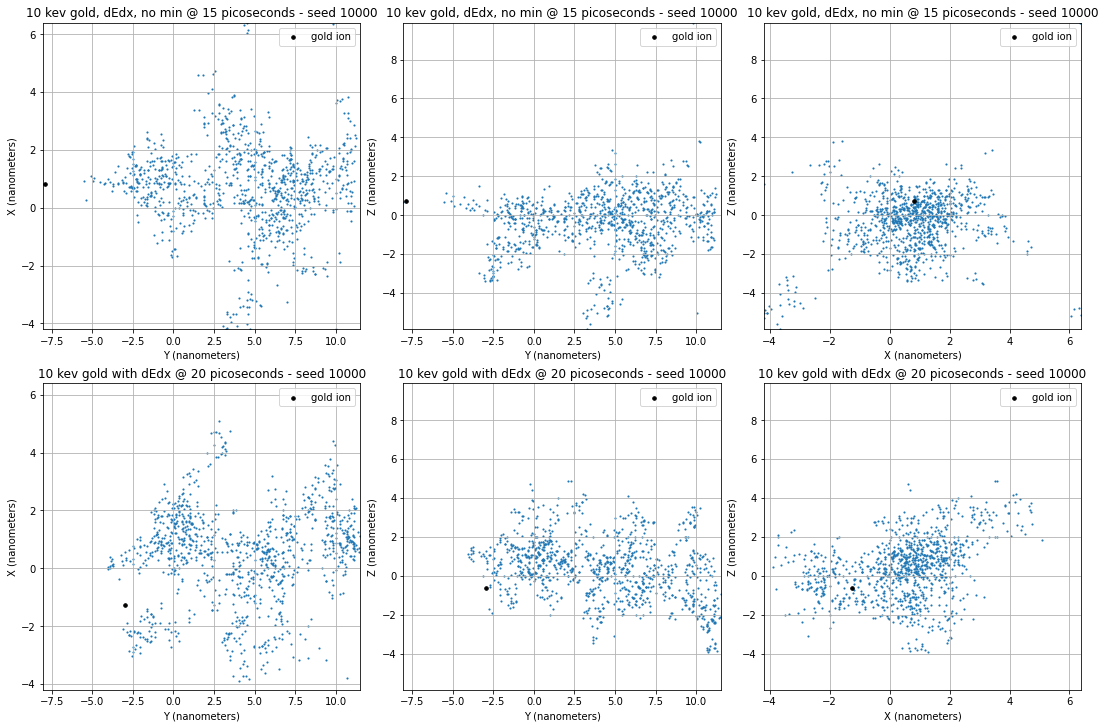

In [500]:
# Original data
data_list = [data_1, data_2, data_3, data_4, data_5]
data_elec_list = [data_elec_1, data_elec_2, data_elec_3, data_elec_4, data_elec_5]

dataframe = 5
data = data_list[dataframe - 1]
data_elec = data_elec_list[dataframe - 1]

x_min, x_max = data['x'].min(), data['x'].max()
y_min, y_max = data['y'].min(), data['y'].max()
z_min, z_max = data['z'].min(), data['z'].max()

x_min_elec, x_max_elec = data_elec['x'].min(), data_elec['x'].max()
y_min_elec, y_max_elec = data_elec['y'].min(), data_elec['y'].max()
z_min_elec, z_max_elec = data_elec['z'].min(), data_elec['z'].max()

x_min, x_max = min(x_min, x_min_elec), max(x_max, x_max_elec)
y_min, y_max = min(y_min, y_min_elec), max(y_max, y_max_elec)
z_min, z_max = min(z_min, z_min_elec), max(z_max, z_max_elec)

######################################################################################

fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)

axes[0,0].scatter(data['y'].values, data['x'].values, s = 5, marker = '.')
axes[0,0].scatter(data[data['type'] == 3]['y'].values, data[data['type'] == 3]['x'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[0,0].set_title(f'10 kev gold, dEdx, no min @ 15 picoseconds - seed {seeds[dataframe-1]}')
axes[0,0].set_xlabel('Y (nanometers)')
axes[0,0].set_ylabel('X (nanometers)')
axes[0,0].legend(loc = 'best')
axes[0,0].grid(True)
axes[0,0].set_xlim(y_min, y_max)
axes[0,0].set_ylim(x_min, x_max)

axes[0,1].scatter(data['y'].values, data['z'].values, s = 5, marker = '.')
axes[0,1].scatter(data[data['type'] == 3]['y'].values, data[data['type'] == 3]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[0,1].set_title(f'10 kev gold, dEdx, no min @ 15 picoseconds - seed {seeds[dataframe-1]}')
axes[0,1].set_xlabel('Y (nanometers)')
axes[0,1].set_ylabel('Z (nanometers)')
axes[0,1].legend(loc = 'best')
axes[0,1].grid(True)
axes[0,1].set_xlim(y_min, y_max)
axes[0,1].set_ylim(z_min, z_max)

axes[0,2].scatter(data['x'].values, data['z'].values, s = 5, marker = '.')
axes[0,2].scatter(data[data['type'] == 3]['x'].values, data[data['type'] == 3]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[0,2].set_title(f'10 kev gold, dEdx, no min @ 15 picoseconds - seed {seeds[dataframe-1]}')
axes[0,2].set_xlabel('X (nanometers)')
axes[0,2].set_ylabel('Z (nanometers)')
axes[0,2].legend(loc = 'best')
axes[0,2].grid(True)
axes[0,2].set_xlim(x_min, x_max)
axes[0,2].set_ylim(z_min, z_max)

######################################################################################

axes[1,0].scatter(data_elec['y'].values, data_elec['x'].values, s = 5, marker = '.')
axes[1,0].scatter(data_elec[data_elec['type'] == 3]['y'].values, data_elec[data_elec['type'] == 3]['x'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[1,0].set_title(f'10 kev gold with dEdx @ 20 picoseconds - seed {seeds[dataframe-1]}')
axes[1,0].set_xlabel('Y (nanometers)')
axes[1,0].set_ylabel('X (nanometers)')
axes[1,0].legend(loc = 'best')
axes[1,0].grid(True)
axes[1,0].set_xlim(y_min, y_max)
axes[1,0].set_ylim(x_min, x_max)

axes[1,1].scatter(data_elec['y'].values, data_elec['z'].values, s = 5, marker = '.')
axes[1,1].scatter(data_elec[data_elec['type'] == 3]['y'].values, data_elec[data_elec['type'] == 3]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[1,1].set_title(f'10 kev gold with dEdx @ 20 picoseconds - seed {seeds[dataframe-1]}')
axes[1,1].set_xlabel('Y (nanometers)')
axes[1,1].set_ylabel('Z (nanometers)')
axes[1,1].legend(loc = 'best')
axes[1,1].grid(True)
axes[1,1].set_xlim(y_min, y_max)
axes[1,1].set_ylim(z_min, z_max)

axes[1,2].scatter(data_elec['x'].values, data_elec['z'].values, s = 5, marker = '.')
axes[1,2].scatter(data_elec[data_elec['type'] == 3]['x'].values, data_elec[data_elec['type'] == 3]['z'].values, s = 50, color = 'black', marker = '.', label = 'gold ion')
axes[1,2].set_title(f'10 kev gold with dEdx @ 20 picoseconds - seed {seeds[dataframe-1]}')
axes[1,2].set_xlabel('X (nanometers)')
axes[1,2].set_ylabel('Z (nanometers)')
axes[1,2].legend(loc = 'best')
axes[1,2].grid(True)
axes[1,2].set_xlim(x_min, x_max)
axes[1,2].set_ylim(z_min, z_max)

### Step 3: Quantify number of vacancies and calculate approximate track length.

In [503]:
num_vacancies1 = [len(data_1[data_1['step'] == step]) for step in steps1]
num_vacancies2 = [len(data_2[data_2['step'] == step]) for step in steps2]
num_vacancies3 = [len(data_3[data_3['step'] == step]) for step in steps3]
num_vacancies4 = [len(data_4[data_4['step'] == step]) for step in steps4]
num_vacancies5 = [len(data_5[data_5['step'] == step]) for step in steps5]

num_vacancies_elec_1 = [len(data_elec_1[data_elec_1['step'] == step]) for step in steps_elec_1]
num_vacancies_elec_2 = [len(data_elec_2[data_elec_2['step'] == step]) for step in steps_elec_2]
num_vacancies_elec_3 = [len(data_elec_3[data_elec_3['step'] == step]) for step in steps_elec_3]
num_vacancies_elec_4 = [len(data_elec_4[data_elec_4['step'] == step]) for step in steps_elec_4]
num_vacancies_elec_5 = [len(data_elec_5[data_elec_5['step'] == step]) for step in steps_elec_5]

####################################################################################################

print(f'For seed {seeds[0]} without dEdX electronic there were {num_vacancies1} vacancies, and with dEdX electronic there were {num_vacancies_elec_1} vacancies.')
print(f'For seed {seeds[1]} without dEdX electronic there were {num_vacancies2} vacancies, and with dEdX electronic there were {num_vacancies_elec_2} vacancies.')
print(f'For seed {seeds[2]} without dEdX electronic there were {num_vacancies3} vacancies, and with dEdX electronic there were {num_vacancies_elec_3} vacancies.')
print(f'For seed {seeds[3]} without dEdX electronic there were {num_vacancies4} vacancies, and with dEdX electronic there were {num_vacancies_elec_4} vacancies.')
print(f'For seed {seeds[4]} with dEdX electronic and without initial minimization there were {num_vacancies5} vacancies, and with dEdX electronic there were {num_vacancies_elec_5} vacancies.')

For seed 50000 without dEdX electronic there were [1243] vacancies, and with dEdX electronic there were [988] vacancies.
For seed 46313 without dEdX electronic there were [1323] vacancies, and with dEdX electronic there were [1012] vacancies.
For seed 40000 without dEdX electronic there were [1271] vacancies, and with dEdX electronic there were [884] vacancies.
For seed 15000 without dEdX electronic there were [1306] vacancies, and with dEdX electronic there were [986] vacancies.
For seed 10000 with dEdX electronic and without initial minimization there were [995] vacancies, and with dEdX electronic there were [1030] vacancies.


### Step 4: Find vacancy density in one specific region

In [504]:
# units of dimensions are in angstroms
x_len1, x_len_elec_1 = np.max(data_1['x'].values) - np.min(data_1['x'].values), np.max(data_elec_1['x'].values) - np.min(data_elec_1['x'].values)
y_len1, y_len_elec_1 = np.max(data_1['y'].values) - np.min(data_1['y'].values), np.max(data_elec_1['y'].values) - np.min(data_elec_1['y'].values)
z_len1, z_len_elec_1 = np.max(data_1['z'].values) - np.min(data_1['z'].values), np.max(data_elec_1['z'].values) - np.min(data_elec_1['z'].values)

x_len2, x_len_elec_2 = np.max(data_2['x'].values) - np.min(data_2['x'].values), np.max(data_elec_2['x'].values) - np.min(data_elec_2['x'].values)
y_len2, y_len_elec_2 = np.max(data_2['y'].values) - np.min(data_2['y'].values), np.max(data_elec_2['y'].values) - np.min(data_elec_2['y'].values)
z_len2, z_len_elec_2 = np.max(data_2['z'].values) - np.min(data_2['z'].values), np.max(data_elec_2['z'].values) - np.min(data_elec_2['z'].values)

x_len3, x_len_elec_3 = np.max(data_3['x'].values) - np.min(data_3['x'].values), np.max(data_elec_3['x'].values) - np.min(data_elec_3['x'].values)
y_len3, y_len_elec_3 = np.max(data_3['y'].values) - np.min(data_3['y'].values), np.max(data_elec_3['y'].values) - np.min(data_elec_3['y'].values)
z_len3, z_len_elec_3 = np.max(data_3['z'].values) - np.min(data_3['z'].values), np.max(data_elec_3['z'].values) - np.min(data_elec_3['z'].values)

x_len4, x_len_elec_4 = np.max(data_4['x'].values) - np.min(data_4['x'].values), np.max(data_elec_4['x'].values) - np.min(data_elec_4['x'].values)
y_len4, y_len_elec_4 = np.max(data_4['y'].values) - np.min(data_4['y'].values), np.max(data_elec_4['y'].values) - np.min(data_elec_4['y'].values)
z_len4, z_len_elec_4 = np.max(data_4['z'].values) - np.min(data_4['z'].values), np.max(data_elec_4['z'].values) - np.min(data_elec_4['z'].values)

x_len5, x_len_elec_5 = np.max(data_5['x'].values) - np.min(data_5['x'].values), np.max(data_elec_5['x'].values) - np.min(data_elec_5['x'].values)
y_len5, y_len_elec_5 = np.max(data_5['y'].values) - np.min(data_5['y'].values), np.max(data_elec_5['y'].values) - np.min(data_elec_5['y'].values)
z_len5, z_len_elec_5 = np.max(data_5['z'].values) - np.min(data_5['z'].values), np.max(data_elec_5['z'].values) - np.min(data_elec_5['z'].values)

volume1, volume2 = ((x_len1) * (y_len1) * (z_len1)), ((x_len2) * (y_len2) * (z_len2))
volume3, volume4, volume5 = ((x_len3) * (y_len3) * (z_len3)), ((x_len4) * (y_len4) * (z_len4)), ((x_len5) * (y_len5) * (z_len5))
volume_elec_1, volume_elec_2 = ((x_len_elec_1) * (y_len_elec_1) * (z_len_elec_1)), ((x_len_elec_2) * (y_len_elec_2) * (z_len_elec_2))
volume_elec_3, volume_elec_4, volume_elec_5 = ((x_len_elec_3) * (y_len_elec_3) * (z_len_elec_3)), ((x_len_elec_4) * (y_len_elec_4) * (z_len_elec_4)), ((x_len_elec_5) * (y_len_elec_5) * (z_len_elec_5))

In [422]:
''' basic generalized formula as of this moment to find vacancy density at a particular slice from yz-plane of desired thickness '''

def vacancy_vs_depth(data, start, end, one_len, two_len): #this works best for one timestep - can modify in the future if needed
    depth = start - end #starting and ending points specified, where start here is specified as the entrance on the right side
    vol = depth * one_len * two_len  # this takes into account a slice of the entire yz-plane at some depth in the x-direction
    num_vacancy = len(data)
    result = num_vacancy / vol
    return result

In [505]:
x_start1, x_end1, x_start_elec_1, x_end_elec_1 = np.max(data_1['x'].values), np.min(data_1['x'].values), np.max(data_elec_1['x'].values), np.min(data_elec_1['x'].values)
y_start1, y_end1, y_start_elec_1, y_end_elec_1 = np.max(data_1['y'].values), np.min(data_1['y'].values), np.max(data_elec_1['y'].values), np.min(data_elec_1['y'].values)
z_start1, z_end1, z_start_elec_1, z_end_elec_1 = np.max(data_1['z'].values), np.min(data_1['z'].values), np.max(data_elec_1['z'].values), np.min(data_elec_1['z'].values)
data_input1, data_elec_input1 = data_1[data_1['step'] == steps1[0]], data_elec_1[data_elec_1['step'] == steps_elec_1[0]]

x_start2, x_end2, x_start_elec_2, x_end_elec_2 = np.max(data_2['x'].values), np.min(data_2['x'].values), np.max(data_elec_2['x'].values), np.min(data_elec_2['x'].values)
y_start2, y_end2, y_start_elec_2, y_end_elec_2 = np.max(data_2['y'].values), np.min(data_2['y'].values), np.max(data_elec_2['y'].values), np.min(data_elec_2['y'].values)
z_start2, z_end2, z_start_elec_2, z_end_elec_2 = np.max(data_2['z'].values), np.min(data_2['z'].values), np.max(data_elec_2['z'].values), np.min(data_elec_2['z'].values)
data_input2, data_elec_input2 = data_2[data_2['step'] == steps2[0]], data_elec_2[data_elec_2['step'] == steps_elec_2[0]]

x_start3, x_end3, x_start_elec_3, x_end_elec_3 = np.max(data_3['x'].values), np.min(data_3['x'].values), np.max(data_elec_3['x'].values), np.min(data_elec_3['x'].values)
y_start3, y_end3, y_start_elec_3, y_end_elec_3 = np.max(data_3['y'].values), np.min(data_3['y'].values), np.max(data_elec_3['y'].values), np.min(data_elec_3['y'].values)
z_start3, z_end3, z_start_elec_3, z_end_elec_3 = np.max(data_3['z'].values), np.min(data_3['z'].values), np.max(data_elec_3['z'].values), np.min(data_elec_3['z'].values)
data_input3, data_elec_input3 = data_3[data_3['step'] == steps3[0]], data_elec_3[data_elec_3['step'] == steps_elec_3[0]]

x_start4, x_end4, x_start_elec_4, x_end_elec_4 = np.max(data_4['x'].values), np.min(data_4['x'].values), np.max(data_elec_4['x'].values), np.min(data_elec_4['x'].values)
y_start4, y_end4, y_start_elec_4, y_end_elec_4 = np.max(data_4['y'].values), np.min(data_4['y'].values), np.max(data_elec_4['y'].values), np.min(data_elec_4['y'].values)
z_start4, z_end4, z_start_elec_4, z_end_elec_4 = np.max(data_4['z'].values), np.min(data_4['z'].values), np.max(data_elec_4['z'].values), np.min(data_elec_4['z'].values)
data_input4, data_elec_input4 = data_4[data_4['step'] == steps4[0]], data_elec_4[data_elec_4['step'] == steps_elec_4[0]]

x_start5, x_end5, x_start_elec_5, x_end_elec_5 = np.max(data_5['x'].values), np.min(data_5['x'].values), np.max(data_elec_5['x'].values), np.min(data_elec_5['x'].values)
y_start5, y_end5, y_start_elec_5, y_end_elec_5 = np.max(data_5['y'].values), np.min(data_5['y'].values), np.max(data_elec_5['y'].values), np.min(data_elec_5['y'].values)
z_start5, z_end5, z_start_elec_5, z_end_elec_5 = np.max(data_5['z'].values), np.min(data_5['z'].values), np.max(data_elec_5['z'].values), np.min(data_elec_5['z'].values)
data_input5, data_elec_input5 = data_5[data_5['step'] == steps5[0]], data_elec_5[data_elec_5['step'] == steps_elec_5[0]]

### Step 6: Make a plot for differing depths what are the predicted vacancy densities (with error to be added soon)

In [506]:
x_end_options = [.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0, 6.0]
y_end_options = [-12, -10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 3.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0]
z_end_options = [-10, -8, -6, -4, -2, -0.5, 0.5, 1.0, 2.0, 2.5, 2.75, 3.0]

result1 = [vacancy_vs_depth(data_input1, y_start1, y, x_len1, z_len1) for y in y_end_options]
result2 = [vacancy_vs_depth(data_input2, y_start2, y, x_len2, z_len2) for y in y_end_options]
result3 = [vacancy_vs_depth(data_input3, y_start3, y, x_len3, z_len3) for y in y_end_options]
result4 = [vacancy_vs_depth(data_input4, y_start4, y, x_len4, z_len4) for y in y_end_options]
result5 = [vacancy_vs_depth(data_input5, y_start5, y, x_len5, z_len5) for y in y_end_options]

result_elec_1 = [vacancy_vs_depth(data_elec_input1, y_start_elec_1, y, x_len_elec_1, z_len_elec_1) for y in y_end_options]
result_elec_2 = [vacancy_vs_depth(data_elec_input2, y_start_elec_2, y, x_len_elec_2, z_len_elec_2) for y in y_end_options]
result_elec_3 = [vacancy_vs_depth(data_elec_input3, y_start_elec_3, y, x_len_elec_3, z_len_elec_3) for y in y_end_options]
result_elec_4 = [vacancy_vs_depth(data_elec_input4, y_start_elec_4, y, x_len_elec_4, z_len_elec_4) for y in y_end_options]
result_elec_5 = [vacancy_vs_depth(data_elec_input5, y_start_elec_5, y, x_len_elec_5, z_len_elec_5) for y in y_end_options]

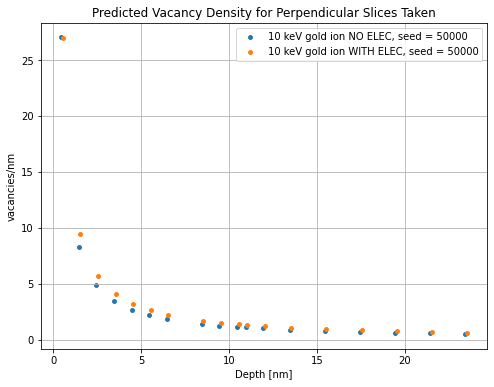

In [511]:
plt.figure(figsize=(8, 6))

y_values1, y_values2 = [y_start1 - y for y in y_end_options], [y_start2 - y for y in y_end_options]
y_values3, y_values4, y_values5 = [y_start3 - y for y in y_end_options], [y_start4 - y for y in y_end_options], [y_start5 - y for y in y_end_options]
y_values_elec_1, y_values_elec_2 = [y_start_elec_1 - y for y in y_end_options], [y_start_elec_2 - y for y in y_end_options]
y_values_elec_3, y_values_elec_4, y_values_elec_5 = [y_start_elec_3 - y for y in y_end_options], [y_start_elec_4 - y for y in y_end_options], [y_start_elec_5 - y for y in y_end_options]

# plt.scatter(y_values1, result1, label = f'10 keV gold ion NO ELEC, seed = {seeds[0]}', s = 15)
# plt.scatter(y_values_elec_1, result_elec_1, label = f'10 keV gold ion WITH ELEC, seed = {seeds[0]}', s = 15)

# plt.scatter(y_values2, result2, label = f'10 keV gold ion NO ELEC, seed = {seeds[1]}', s = 15)
# plt.scatter(y_values_elec_2, result_elec_2, label = f'10 keV gold ion WITH ELEC, seed = {seeds[1]}', s = 15)

# plt.scatter(y_values3, result3, label = f'10 keV gold ion NO ELEC, seed = {seeds[2]}', s = 15)
# plt.scatter(y_values_elec_3, result_elec_3, label = f'10 keV gold ion WITH ELEC, seed = {seeds[2]}', s = 15)

# plt.scatter(y_values4, result4, label = f'10 keV gold ion NO ELEC, seed = {seeds[3]}', s = 15)
# plt.scatter(y_values_elec_4, result_elec_4, label = f'10 keV gold ion WITH ELEC, seed = {seeds[3]}', s = 15)

#plt.scatter(y_values5, result5, label = f'10 keV gold ion WITH ELEC NO MIN, seed = {seeds[4]}', s = 15)
#plt.scatter(y_values_elec_5, result_elec_5, label = f'10 keV gold ion WITH ELEC, seed = {seeds[4]}', s = 15)

plt.title(f'Predicted Vacancy Density for Perpendicular Slices Taken')
plt.xlabel('Depth [nm]')
plt.ylabel('vacancies/nm')
plt.legend(loc = 'best')
plt.grid(True)

### Step 7: Subtract the displaced atoms from the original configuration to visualize what the created track would more realistically look like!

In [ ]:
'''

Just like the header says, we're subtracting out the intersticial atoms to give the resulting cube without the tracks inside. 
This will give a better visualization of understanding the track length and width visually and compares moreso with the tracks we are actually
irradiating and measuring. 

#note: the cell will probably take a few minutes depending on how large the lattice is that was loaded in because there are many hundreds of 
thousands of atoms that need to be plotted (vs a few hundred/thousand intersticial atoms).

Note to self: this doesn't actually show the track very well. you would need to zoom in a lot more in all directions to the range of damage just
because there are so many atoms. 

'''

In [512]:
#load in the dataframes of the original crystals after minimization and temperature settling 
######################################################################################################################

original_crystal1, original_crystal2 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_50000_original', sep = " "), pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_43613_original', sep = " ")
original_crystal3, original_crystal4 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_40000_original', sep = " "), pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_15000_original', sep = " ")
original_crystal5 = pd.read_csv('5_14_2025_runs/5_14_2025_10keV_ters_zbl_10000_original', sep = " ")

data1ids, data2ids, data3ids, data4ids, data5ids = data_1['id'].values, data_2['id'].values, data_3['id'].values, data_4['id'].values, data_5['id'].values 
og1ids, og2ids = original_crystal1['id'].values, original_crystal2['id'].values
og3ids, og4ids, og5ids = original_crystal3['id'].values, original_crystal4['id'].values, original_crystal5['id'].values

data_1_mods, data_2_mods = np.setdiff1d(og1ids, data1ids), np.setdiff1d(og2ids, data2ids) #find the ids found in both
data_3_mods, data_4_mods, data_5_mods = np.setdiff1d(og3ids, data3ids), np.setdiff1d(og4ids, data4ids), np.setdiff1d(og5ids, data5ids)

data_1_mod, data_2_mod = original_crystal1[original_crystal1['id'].isin(data_1_mods)], original_crystal2[original_crystal2['id'].isin(data_2_mods)]
data_3_mod, data_4_mod = original_crystal3[original_crystal3['id'].isin(data_3_mods)], original_crystal4[original_crystal4['id'].isin(data_4_mods)]
data_5_mod = original_crystal5[original_crystal5['id'].isin(data_5_mods)]

vacancies_1, vacancies_2 = original_crystal1[original_crystal1['id'].isin(data1ids)], original_crystal2[original_crystal2['id'].isin(data2ids)]
vacancies_3, vacancies_4 = original_crystal3[original_crystal3['id'].isin(data3ids)], original_crystal4[original_crystal4['id'].isin(data4ids)]
vacancies_5 = original_crystal5[original_crystal5['id'].isin(data5ids)]

######################################################################################################################

original_crystal_elec_1, original_crystal_elec_2 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_50000_original_elec', sep = " "), pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_46313_original_elec', sep = " ")
original_crystal_elec_3, original_crystal_elec_4 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_40000_original_elec', sep = " "), pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_15000_original_elec', sep = " ")
original_crystal_elec_5 = pd.read_csv('5_15_2025_runs/5_15_2025_10keV_ters_zbl_10000_original_elec', sep = " ")

data1_elec_ids, data2_elec_ids, data3_elec_ids, data4_elec_ids, data5_elec_ids = data_elec_1['id'].values, data_elec_2['id'].values, data_elec_3['id'].values, data_elec_4['id'].values, data_elec_5['id'].values 
og1_elec_ids, og2_elec_ids = original_crystal_elec_1['id'].values, original_crystal_elec_2['id'].values
og3_elec_ids, og4_elec_ids, og5_elec_ids = original_crystal_elec_3['id'].values, original_crystal_elec_4['id'].values, original_crystal_elec_5['id'].values

data_1_elec_mods, data_2_elec_mods = np.setdiff1d(og1_elec_ids, data1_elec_ids), np.setdiff1d(og2_elec_ids, data2_elec_ids) #find the ids found in both
data_3_elec_mods, data_4_elec_mods, data_5_elec_mods = np.setdiff1d(og3_elec_ids, data3_elec_ids), np.setdiff1d(og4_elec_ids, data4_elec_ids), np.setdiff1d(og5_elec_ids, data5_elec_ids)

data_1_elec_mod, data_2_elec_mod = original_crystal_elec_1[original_crystal_elec_1['id'].isin(data_1_elec_mods)], original_crystal_elec_2[original_crystal_elec_2['id'].isin(data_2_elec_mods)]
data_3_elec_mod, data_4_elec_mod = original_crystal_elec_3[original_crystal_elec_3['id'].isin(data_3_elec_mods)], original_crystal_elec_4[original_crystal_elec_4['id'].isin(data_4_elec_mods)]
data_5_elec_mod = original_crystal_elec_5[original_crystal_elec_5['id'].isin(data_5_elec_mods)]

vacancies_elec_1, vacancies_elec_2 = original_crystal_elec_1[original_crystal_elec_1['id'].isin(data1_elec_ids)], original_crystal_elec_2[original_crystal_elec_2['id'].isin(data2_elec_ids)]
vacancies_elec_3, vacancies_elec_4 = original_crystal_elec_3[original_crystal_elec_3['id'].isin(data3_elec_ids)], original_crystal_elec_4[original_crystal_elec_4['id'].isin(data4_elec_ids)]
vacancies_elec_5 = original_crystal_elec_5[original_crystal_elec_5['id'].isin(data5_elec_ids)]

######################################################################################################################

data_1_mod.loc[:, 'x'], data_2_mod.loc[:, 'x'] = data_1_mod['x'] / 10, data_2_mod['x'] / 10
data_1_mod.loc[:, 'y'], data_2_mod.loc[:, 'y'] = data_1_mod['y'] / 10, data_2_mod['y'] / 10
data_1_mod.loc[:, 'z'], data_2_mod.loc[:, 'z'] = data_1_mod['z'] / 10, data_2_mod['z'] / 10

data_3_mod.loc[:, 'x'], data_4_mod.loc[:, 'x'] = data_3_mod['x'] / 10, data_4_mod['x'] / 10
data_3_mod.loc[:, 'y'], data_4_mod.loc[:, 'y'] = data_3_mod['y'] / 10, data_4_mod['y'] / 10
data_3_mod.loc[:, 'z'], data_4_mod.loc[:, 'z'] = data_3_mod['z'] / 10, data_4_mod['z'] / 10

data_5_mod.loc[:, 'x'] = data_5_mod['x'] / 10
data_5_mod.loc[:, 'y'] = data_5_mod['y'] / 10
data_5_mod.loc[:, 'z'] = data_5_mod['z'] / 10

vacancies_1.loc[:, 'x'], vacancies_2.loc[:, 'x'] = vacancies_1['x'] / 10, vacancies_2['x'] / 10
vacancies_1.loc[:, 'y'], vacancies_2.loc[:, 'y'] = vacancies_1['y'] / 10, vacancies_2['y'] / 10
vacancies_1.loc[:, 'z'], vacancies_2.loc[:, 'z'] = vacancies_1['z'] / 10, vacancies_2['z'] / 10

vacancies_3.loc[:, 'x'], vacancies_4.loc[:, 'x'] = vacancies_3['x'] / 10, vacancies_4['x'] / 10
vacancies_3.loc[:, 'y'], vacancies_4.loc[:, 'y'] = vacancies_3['y'] / 10, vacancies_4['y'] / 10
vacancies_3.loc[:, 'z'], vacancies_4.loc[:, 'z'] = vacancies_3['z'] / 10, vacancies_4['z'] / 10

vacancies_5.loc[:, 'x'] = vacancies_5['x'] / 10
vacancies_5.loc[:, 'y'] = vacancies_5['y'] / 10
vacancies_5.loc[:, 'z'] = vacancies_5['z'] / 10

######################################################################################################################

data_1_elec_mod.loc[:, 'x'], data_2_elec_mod.loc[:, 'x'] = data_1_elec_mod['x'] / 10, data_2_elec_mod['x'] / 10
data_1_elec_mod.loc[:, 'y'], data_2_elec_mod.loc[:, 'y'] = data_1_elec_mod['y'] / 10, data_2_elec_mod['y'] / 10
data_1_elec_mod.loc[:, 'z'], data_2_elec_mod.loc[:, 'z'] = data_1_elec_mod['z'] / 10, data_2_elec_mod['z'] / 10

data_3_elec_mod.loc[:, 'x'], data_4_elec_mod.loc[:, 'x'] = data_3_elec_mod['x'] / 10, data_4_elec_mod['x'] / 10
data_3_elec_mod.loc[:, 'y'], data_4_elec_mod.loc[:, 'y'] = data_3_elec_mod['y'] / 10, data_4_elec_mod['y'] / 10
data_3_elec_mod.loc[:, 'z'], data_4_elec_mod.loc[:, 'z'] = data_3_elec_mod['z'] / 10, data_4_elec_mod['z'] / 10

data_5_elec_mod.loc[:, 'x'] = data_5_elec_mod['x'] / 10
data_5_elec_mod.loc[:, 'y'] = data_5_elec_mod['y'] / 10
data_5_elec_mod.loc[:, 'z'] = data_5_elec_mod['z'] / 10

vacancies_elec_1.loc[:, 'x'], vacancies_elec_2.loc[:, 'x'] = vacancies_elec_1['x'] / 10, vacancies_elec_2['x'] / 10
vacancies_elec_1.loc[:, 'y'], vacancies_elec_2.loc[:, 'y'] = vacancies_elec_1['y'] / 10, vacancies_elec_2['y'] / 10
vacancies_elec_1.loc[:, 'z'], vacancies_elec_2.loc[:, 'z'] = vacancies_elec_1['z'] / 10, vacancies_elec_2['z'] / 10

vacancies_elec_3.loc[:, 'x'], vacancies_elec_4.loc[:, 'x'] = vacancies_elec_3['x'] / 10, vacancies_elec_4['x'] / 10
vacancies_elec_3.loc[:, 'y'], vacancies_elec_4.loc[:, 'y'] = vacancies_elec_3['y'] / 10, vacancies_elec_4['y'] / 10
vacancies_elec_3.loc[:, 'z'], vacancies_elec_4.loc[:, 'z'] = vacancies_elec_3['z'] / 10, vacancies_elec_4['z'] / 10

vacancies_elec_5.loc[:, 'x'] = vacancies_elec_5['x'] / 10
vacancies_elec_5.loc[:, 'y'] = vacancies_elec_5['y'] / 10
vacancies_elec_5.loc[:, 'z'] = vacancies_elec_5['z'] / 10

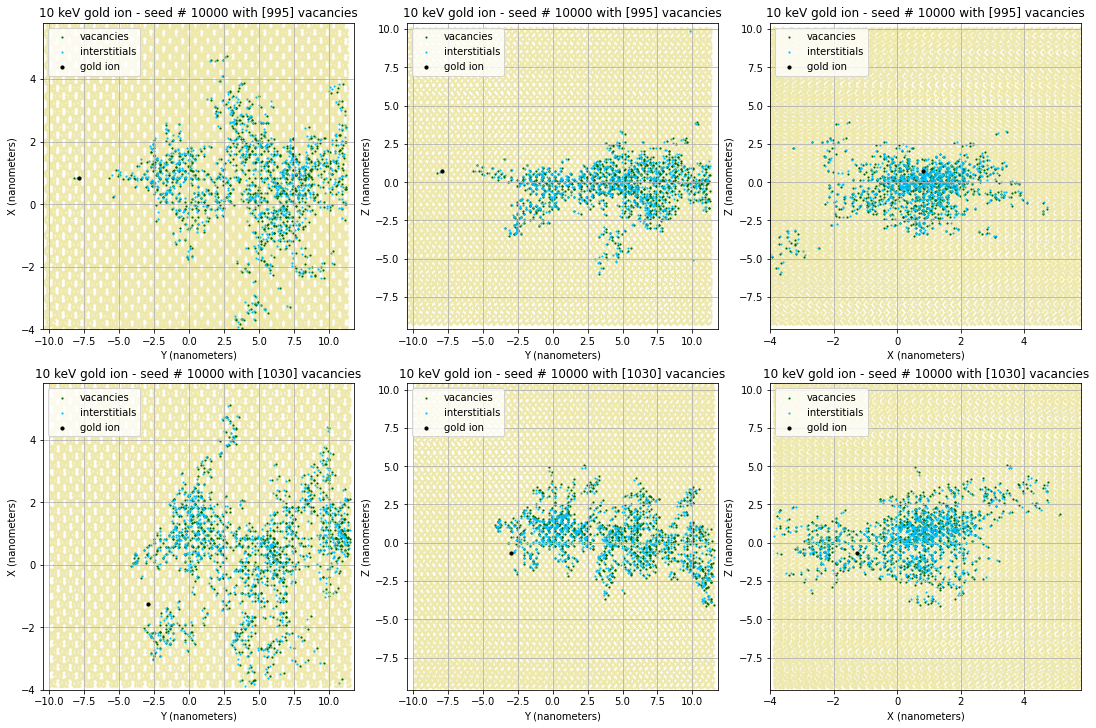

In [515]:
# visualize the resulting damage similar to above
mod_data = [data_1_mod, data_2_mod, data_3_mod, data_4_mod, data_5_mod]
elec_data = [data_1_elec_mod, data_2_elec_mod, data_3_elec_mod, data_4_elec_mod, data_5_elec_mod]
vacancies = [vacancies_1, vacancies_2, vacancies_3, vacancies_4, vacancies_5]
elec_vacancies = [vacancies_elec_1, vacancies_elec_2, vacancies_elec_3, vacancies_elec_4, vacancies_elec_5]
original_data = [data_1, data_2, data_3, data_4, data_5]
original_elec_data = [data_elec_1, data_elec_2, data_elec_3, data_elec_4, data_elec_5]
num_vacancies = [num_vacancies1, num_vacancies2, num_vacancies3, num_vacancies4, num_vacancies5]
num_elec_vacancies = [num_vacancies_elec_1, num_vacancies_elec_2, num_vacancies_elec_3, num_vacancies_elec_4, num_vacancies_elec_5]

x_min = min(df['x'].min() for df in mod_data)
x_max = max(df['x'].max() for df in mod_data)
y_min = min(df['y'].min() for df in mod_data)
y_max = max(df['y'].max() for df in mod_data)
z_min = min(df['z'].min() for df in mod_data)
z_max = max(df['z'].max() for df in mod_data)

######################################################################################

def plot_damage(ax, mod, vac, orig, seed, num_vac, axis1, axis2, axis_labels, limits, title_suffix=""):
    ax.scatter(mod[axis1], mod[axis2], s=1, marker='.', color='palegoldenrod', alpha=0.45)
    ax.scatter(vac[axis1], vac[axis2], s=5, marker='.', color='darkgreen', label='vacancies')
    ax.scatter(orig[axis1], orig[axis2], s=5, marker='.', color='deepskyblue', label='interstitials')
    ax.scatter(orig[orig['type'] == 3][axis1], orig[orig['type'] == 3][axis2], s=40, color='black', marker='.', label='gold ion')
    ax.set_title(f'10 keV gold ion - seed # {seed} with {num_vac} vacancies{title_suffix}')
    ax.set_xlabel(f"{axis_labels[0]} (nanometers)")
    ax.set_ylabel(f"{axis_labels[1]} (nanometers)")
    ax.legend(loc='upper left')
    ax.grid(True)
    ax.set_xlim(*limits[axis1]
    ax.set_ylim(*limits[axis2])

######################################################################################    

limits = {'x': (x_min, x_max), 'y': (y_min, y_max), 'z': (z_min, z_max)}

axis_pairs = [('y', 'x'), ('y', 'z'), ('x', 'z')]
axis_labels = {'x': 'X', 'y': 'Y','z': 'Z'}

fig, axes = plt.subplots(2, 3, figsize=(15, 10), constrained_layout=True)
dataframe = 5

for i, (a1, a2) in enumerate(axis_pairs):
    plot_damage(ax = axes[0, i], mod = mod_data[dataframe - 1], vac = vacancies[dataframe - 1], orig = original_data[dataframe - 1], seed = seeds[dataframe - 1],
        num_vac = num_vacancies[dataframe - 1], axis1 = a1, axis2 = a2, axis_labels = (axis_labels[a1], axis_labels[a2]), limits = limits)

for i, (a1, a2) in enumerate(axis_pairs):
    plot_damage(ax = axes[1, i], mod = elec_data[dataframe - 1], vac = elec_vacancies[dataframe - 1], orig = original_elec_data[dataframe - 1], seed = seeds[dataframe - 1],
        num_vac = num_elec_vacancies[dataframe - 1], axis1 = a1, axis2 = a2, axis_labels = (axis_labels[a1], axis_labels[a2]), limits = limits)

### Step 8: Analyze the statistics when executing the same simulation multiple times.

In [463]:
def analyze_stats(n, *inputs):
    """
    This function takes in an integer n that corresponds to the number of dataframes inputted, 
    and various inputs starting with all of the inputted dataframes and following with desired 
    other inputs such as the saved track lengths in the previous cell. The function then analyzes 
    the statistics of these inputs and computes the mean, median, variance, and standard deviation 
    values for all inputs loaded in.

    ORDER OF STATS PRINTED:
    1) Vacancy information - first load in dataframes
    2) Total damage track depths - second load in track depth information
    3) Gold track depth - third load in gold track depth information
    """

    print(f"Processing {n} runs")

    vacancy_counts, tot_tracks, gold_tracks = [], [], []

    dfs = inputs[:n]
    #tot_track = inputs[n:2*n]
    #gold_track = inputs[2*n:3*n]

    for i, df in enumerate(dfs):
        print(f"DataFrame {i+1} shape: {df.shape}")  

        # grab number of vacancies from each dataframe
        first_step = df['step'].iloc[0]
        num_vacancies = len(df[df['step'] == first_step])
        print(f"Run {i+1} had {num_vacancies} total vacancies")
        vacancy_counts.append(num_vacancies)

    # find stats on the vacancies
    mean_val = np.mean(vacancy_counts)
    median_val = np.median(vacancy_counts)
    variance_val = np.var(vacancy_counts)  
    std_dev_val = np.std(vacancy_counts) 

    print(f"\nSummary statistics across {n} runs with different seeds:")
    print(f"Mean # of vacancies: {mean_val}")
    print(f"Median # of vacancies: {median_val}")
    print(f"Variance: {variance_val:.1f}; STD: {std_dev_val:.1f}\n")

   # for j in range(n):
   #     track_val = np.array(tot_track[j]).item()  # Get scalar from single-item list
   #     print(f"Run {j+1} had a total damage track length of {track_val:.4f} nm.")
   #     tot_tracks.append(track_val)

   # print(f"\nSummary statistics for track lengths across runs with different seeds:")
   # print(f"Mean: {np.mean(tot_tracks):.2f}; Median: {np.median(tot_tracks):.2f}")
   # print(f"Variance: {np.var(tot_tracks):.2f}; STD: {np.std(tot_tracks):.2f}\n")

   # for k in range(n):
   #     gold_val = np.array(gold_track[k]).item()  # Get scalar from single-item list
   #     print(f"Run {k+1} had the gold ion travel {gold_val:.4f} nm.")
   #     gold_tracks.append(gold_val)

    #print(f"\nSummary statistics for distance gold traveled across runs with different seeds:")
    #print(f"Mean: {np.mean(gold_tracks):.2f}; Median: {np.median(gold_tracks):.2f}")
    #print(f"Variance: {np.var(gold_tracks):.2f}; STD: {np.std(gold_tracks):.2f}")


In [464]:
num_dfs = 5
analyze_stats(num_dfs, data_1, data_2, data_3, data_4, data_5)
analyze_stats(num_dfs, data_elec_1, data_elec_2, data_elec_3, data_elec_4, data_elec_5)

Processing 5 runs
DataFrame 1 shape: (1243, 7)
Run 1 had 1243 total vacancies
DataFrame 2 shape: (1323, 7)
Run 2 had 1323 total vacancies
DataFrame 3 shape: (1271, 7)
Run 3 had 1271 total vacancies
DataFrame 4 shape: (1306, 7)
Run 4 had 1306 total vacancies
DataFrame 5 shape: (1350, 7)
Run 5 had 1350 total vacancies

Summary statistics across 5 runs with different seeds:
Mean # of vacancies: 1298.6
Median # of vacancies: 1306.0
Variance: 1429.0; STD: 37.8

Processing 5 runs
DataFrame 1 shape: (988, 7)
Run 1 had 988 total vacancies
DataFrame 2 shape: (1012, 7)
Run 2 had 1012 total vacancies
DataFrame 3 shape: (884, 7)
Run 3 had 884 total vacancies
DataFrame 4 shape: (986, 7)
Run 4 had 986 total vacancies
DataFrame 5 shape: (1030, 7)
Run 5 had 1030 total vacancies

Summary statistics across 5 runs with different seeds:
Mean # of vacancies: 980.0
Median # of vacancies: 988.0
Variance: 2568.0; STD: 50.7



### Step 9: Calculate the track width and length.

In [ ]:
'''

this is divided into multiple parts. first we need to define a gaussian function for each depth input with a certain thickness
that counts the number of interstitials and vacancy sites in said thickness slice -> think something like the following
num_vac = np.sum(data['y'] > depth - tol + data['y'] < depth + tol)

then towards the beginning plot the density of vacancies as a function of gaussian radius, this should look gaussian. from this plot we need
to define a threshold at what point do we define the width to be - then in the future use this threshold to automatically stop the function from 
continuing to grow and recalculate and simply move on.

for each depth, the recorded width will be saved and this process is repeated increasing the depth further into the crystal sample until 
at some point we reach a threshold and the track has concluded

**** this is a work in progress ****


'''

In [147]:
with open("Au_stopping_power", "r") as file:
    lines = file.readlines()

data = []

for line in lines:
    line = line.strip()
    if not line or line.startswith("Energy"):
        continue  # Skip header or empty lines

    # Normalize spaces
    parts = re.split(r'\s+', line)

    # Extract energy and its unit
    energy_val = float(parts[0])
    energy_unit = parts[1]
    
    if energy_unit == 'keV':
        energy = energy_val
    elif energy_unit == 'eV':
        energy = energy_val / 1000  # convert eV to keV
    elif energy_unit == 'MeV':
        energy = energy_val * 1000 #convert keV to MeV
    else:
        raise ValueError(f"Unexpected energy unit: {energy_unit}")
    
    # Process the remaining values, ensure they are numeric
    try:
        elec_stopping = float(parts[2])  # e.g., Electronic stopping
    except ValueError:
        elec_stopping = None  # If not numeric, set as None or skip
    
    try:
        nucl_stopping = float(parts[3])  # e.g., Nuclear stopping
    except ValueError:
        nucl_stopping = None  # If not numeric, set as None or skip
    
    try:
        range_A = float(parts[4])  # Range in Ångstroms
    except ValueError:
        range_A = None  # If not numeric, set as None or skip
    
    try:
        long_straggling_A = float(parts[5])  # Longitudinal Straggling in Å
    except ValueError:
        long_straggling_A = None  # If not numeric, set as None or skip
    
    try:
        lat_straggling_A = float(parts[6])  # Lateral Straggling in Å
    except ValueError:
        lat_straggling_A = None  # If not numeric, set as None or skip

    # Convert Angstroms to nm
    range_nm = range_A * 0.1 if range_A else None
    long_straggling_nm = long_straggling_A * 0.1 if long_straggling_A else None
    lat_straggling_nm = lat_straggling_A * 0.1 if lat_straggling_A else None

    # Append the data row
    data.append([energy, elec_stopping, nucl_stopping, range_nm,
                 long_straggling_nm, lat_straggling_nm])

# Create DataFrame
columns = ["Energy (keV)", "Electronic Stopping (eV/Å)", "Nuclear Stopping (eV/Å)",
           "Range (nm)", "Longitudinal Straggling (nm)", "Lateral Straggling (nm)"]

df = pd.DataFrame(data, columns=columns)

df

,Energy (keV),Electronic Stopping (eV/Å),Nuclear Stopping (eV/Å),Range (nm),Longitudinal Straggling (nm),Lateral Straggling (nm)
0,0.10,15.02,141.9,1.5,None,0.4
1,0.10,15.02,141.9,1.5,None,0.4
2,0.11,15.75,150.6,1.6,None,0.4
3,0.12,16.45,159.0,1.6,None,0.4
4,0.13,17.12,167.1,1.7,None,0.4
...,...,...,...,...,...,...
110,1500.00,1752.00,3214.0,311.2,None,40.1
111,1600.00,1789.00,3160.0,330.7,None,42.1
112,1700.00,1826.00,3107.0,350.3,None,44.0
113,1800.00,1862.00,3056.0,369.9,None,46.0


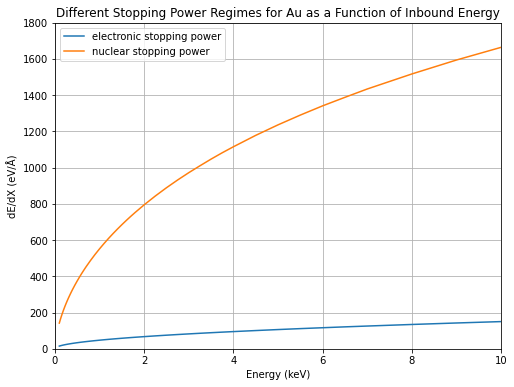

In [374]:
fig = plt.figure(figsize=(8, 6))
plt.plot(df['Energy (keV)'].values, df['Electronic Stopping (eV/Å)'].values, label = 'electronic stopping power')
plt.plot(df['Energy (keV)'].values, df['Nuclear Stopping (eV/Å)'].values, label = 'nuclear stopping power')
plt.title('Different Stopping Power Regimes for Au as a Function of Inbound Energy')
plt.xlabel('Energy (keV)')
plt.ylabel('dE/dX (eV/Å)')
plt.legend(loc = 'best')
plt.xlim(0, 10)
plt.ylim(0, 1800)
plt.grid(True)

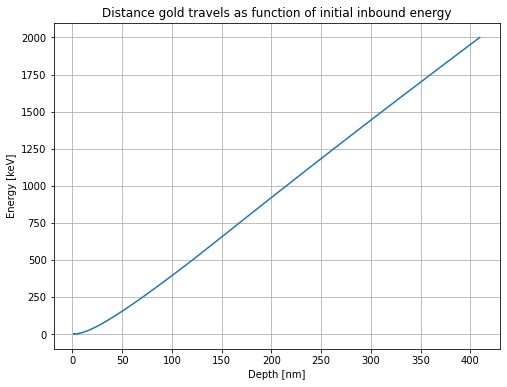

In [368]:
fig = plt.figure(figsize=(8, 6))
plt.plot(df['Range (nm)'].values, df['Energy (keV)'].values)
plt.title('Distance gold travels as function of initial inbound energy')
plt.xlabel('Depth [nm]')
plt.ylabel('Energy [keV]')
plt.grid(True)